In [307]:
import pandas as pd
import numpy as np
from scipy.io import arff
import tensorflow as tf
from tensorflow.keras import layers, backend 

import time
from typing import Tuple, List
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [308]:
class GAN:
    def __init__(self, latent_dim, gen_out_size, gen_dense_sizes: List[int], dis_dense_sizes: List[int], gen_final_activation='tanh' ):
        self.latent_dim = latent_dim
        self.generator_vector_size = gen_out_size
        self.discriminator_input_shape = (self.generator_vector_size,)

        self.generator = self.make_generator_model(gen_dense_sizes, gen_final_activation)
        self.discriminator = self.make_discriminator_model(dis_dense_sizes)
        self.gan = self.combime_gan(self.generator, self.discriminator)

    def combime_gan(self, g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False
        # connect generator and discriminator
        model = tf.keras.Sequential()
        model.add(g_model)
        model.add(d_model)
        # opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5) # lr=0.0002, beta_1=0.5, beta_2=0.999
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.6,beta_2=0.999 )
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    def make_generator_model(self, dis_dense_sizes: List[int], gen_final_activation):
        model = tf.keras.Sequential()

        first_layer = True
        for layer_size in dis_dense_sizes:
            if first_layer:
                model.add(layers.Dense(layer_size, input_dim=self.latent_dim))
                first_layer = False
            else:
                model.add(layers.Dense(layer_size))
            model.add(layers.BatchNormalization())
            model.add(layers.LeakyReLU())
            model.add(layers.Dropout(0.25))

        model.add(layers.Dense(self.generator_vector_size, activation=gen_final_activation))

        model.summary()
        return model

    def make_discriminator_model(self, dis_dense_sizes: List[int]):
        model = tf.keras.Sequential()
        first_layer = True
        for layer_size in dis_dense_sizes:
            if first_layer:
                model.add(layers.Dense(layer_size, input_dim=self.generator_vector_size))
                first_layer = False
            else:
                model.add(layers.Dense(layer_size))
            # model.add(layers.BatchNormalization())
            model.add(layers.LeakyReLU())
            model.add(layers.Dropout(0.2))

        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        # Carmel - note for report, lr made lower here x10 than Generator because 
        # when equel the D outpreformed G and loss could not converge so idea is to make D learn slower so that G could be an adversary

        # opt = tf.keras.optimizers.Adam(lr=0.00002, beta_1=0.5)  # lr=0.0002, beta_1=0.5, beta_2=0.999
        # opt = tf.keras.optimizers.Adam(lr=0.00002, beta_1=0.8)  # lr=0.0002, beta_1=0.5, beta_2=0.999
        opt = tf.keras.optimizers.Adam(lr=0.000015, beta_1=0.95)  # lr=0.0002, beta_1=0.5, beta_2=0.999
        # opt = tf.keras.optimizers.Adam(lr=0.000015, beta_1=0.90,beta_2=0.99 )  # lr=0.0002, beta_1=0.5, beta_2=0.999
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.summary()
        return model



    def generate_real_x_y(self, data: np.ndarray, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        y_real = np.ones((n_samples, 1))
        idx = np.random.randint(0, data.shape[0], n_samples)
        x_real = data[idx]
        return x_real, y_real

    def generate_fake_x_y(self, n_samples: int) -> Tuple[np.ndarray, np.ndarray]:
        y_fake = np.zeros((n_samples, 1))
        noise = np.random.normal(0, 1, (n_samples, self.latent_dim))
        x_fake = self.generator.predict(noise)
        return x_fake, y_fake


    def train(self, df, epochs, batch_size=8):
        # (X_train, _), (_, _) = mnist.load_data()
        # X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)
        X_train = df.values
        valid = np.ones((batch_size, 1))
        valid_twice = np.ones((batch_size * 2, 1))
        fake = np.zeros((batch_size, 1))
        d_losses = np.zeros((epochs, 1))
        d_accuracies = np.zeros((epochs, 1))
        d_fake_losses = np.zeros((epochs, 1))
        d_fake_accuracies = np.zeros((epochs, 1))
        d_real_losses = np.zeros((epochs, 1))
        d_real_accuracies = np.zeros((epochs, 1))
        g_losses = np.zeros((epochs, 1))
        g_accuracies = np.zeros((epochs, 1))

        for i, epoch in enumerate(range(epochs)):
            # prepare real fake examples
            x_fake, y_fake = self.generate_fake_x_y(batch_size)
            x_real, y_real = self.generate_real_x_y(X_train, batch_size)
            
            # Carmel - try this            
            # set discriminator learning rate:
            # current_learning_rate = self.discriminator.optimizer.learning_rate * 0.999
            # backend.set_value(self.discriminator.optimizer.learning_rate, current_learning_rate)  # set new learning_rate


            # create training set for the discriminator
            x, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, d_acc = self.discriminator.train_on_batch(x, y)

            # evaluate discriminator on real examples
            x_real, y_real = self.generate_real_x_y(X_train, batch_size)
            d_loss_real, d_acc_real = self.discriminator.evaluate(x_real, y_real, verbose=0)
            # evaluate discriminator on fake examples
            x_fake, y_fake = self.generate_fake_x_y(batch_size)
            d_loss_fake, d_acc_fake = self.discriminator.evaluate(x_fake, y_fake, verbose=0)

            d_fake_losses[i] = d_loss_fake
            d_real_losses[i] = d_loss_real
            d_fake_accuracies[i] = d_acc_fake
            d_real_accuracies[i] = d_acc_real

            noise = np.random.normal(0, 1, (batch_size * 2, self.latent_dim))
            # create inverted labels for the fake samples so generator can improve to be 'real'
            # update the generator via the discriminator's error
            g_loss, g_acc = self.gan.train_on_batch(noise, valid_twice)

            d_losses[i] = d_loss
            d_accuracies[i] = d_acc
            g_losses[i] = g_loss
            g_accuracies[i] = g_acc

            if i % 50 == 0:
              print("iter %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
              # if 800<=i and i<= 1200:
              #   filename = 'generator_model_%03d.h5' % (epoch + 1)
              #   self.generator.save(filename)

        return d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies
      

In [309]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [310]:
# diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/german_credit.arff')

In [311]:
def load_data() -> pd.DataFrame:
    diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/german_credit.arff')
    diab_df = pd.DataFrame(diab_arf[0])
    return diab_df
    
def prepare():
    cred_df = load_data()
    y = cred_df.pop('21')
    # print(cred_df.describe())
    cat_labels = ['1', '3', '4', '6', '7', '9', '10', '12', '14', '15', '17', '19', '20']
    # One hot encoding
    df = pd.get_dummies(cred_df, columns=cat_labels)
    df = df.astype('float')
    # numeric scaling
    scale = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scale.fit_transform(df)
    df.loc[:, :] = scaled_values
    # scale = MinMaxScaler(feature_range=(-1, 1))
    # df['2'] = scale.fit_transform(df['2'].values.reshape(-1, 1))
    # df['5'] = scale.fit_transform(df['5'].values.reshape(-1, 1))
    # df['8'] = scale.fit_transform(df['8'].values.reshape(-1, 1))
    # df['11'] = scale.fit_transform(df['11'].values.reshape(-1, 1))
    # df['13'] = scale.fit_transform(df['13'].values.reshape(-1, 1))
    # df['16'] = scale.fit_transform(df['16'].values.reshape(-1, 1))
    # df['18'] = scale.fit_transform(df['18'].values.reshape(-1, 1))
    return df

In [312]:
df_credit = prepare()
df_credit.head()
# df_credit.describe()

,2,5,8,11,13,16,18,1_b'A11',1_b'A12',1_b'A13',1_b'A14',3_b'A30',3_b'A31',3_b'A32',3_b'A33',3_b'A34',4_b'A40',4_b'A41',4_b'A410',4_b'A42',4_b'A43',4_b'A44',4_b'A45',4_b'A46',4_b'A48',4_b'A49',6_b'A61',6_b'A62',6_b'A63',6_b'A64',6_b'A65',7_b'A71',7_b'A72',7_b'A73',7_b'A74',7_b'A75',9_b'A91',9_b'A92',9_b'A93',9_b'A94',10_b'A101',10_b'A102',10_b'A103',12_b'A121',12_b'A122',12_b'A123',12_b'A124',14_b'A141',14_b'A142',14_b'A143',15_b'A151',15_b'A152',15_b'A153',17_b'A171',17_b'A172',17_b'A173',17_b'A174',19_b'A191',19_b'A192',20_b'A201',20_b'A202'
0,-0.941176,-0.898867,1.000000,1.000000,0.714286,-0.333333,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0
1,0.294118,-0.372620,-0.333333,-0.333333,-0.892857,-1.000000,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0
2,-0.764706,-0.796853,-0.333333,0.333333,0.071429,-1.000000,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0
3,0.117647,-0.160119,-0.333333,1.000000,-0.071429,-1.000000,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0
4,-0.411765,-0.491581,0.333333,1.000000,0.214286,-0.333333,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0


In [313]:
iterations = 8000
gan = GAN(30, 61, [128, 256, 512], [512, 256, 128], 'tanh')
# gan = GAN(20, 61, [60, 30], [64, 32], 'sigmoid')
d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies = gan.train(df=df_credit, epochs=iterations, batch_size=32)



Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 128)               3968      
_________________________________________________________________
batch_normalization_63 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_132 (LeakyReLU)  (None, 128)               0         
_________________________________________________________________
dropout_132 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_64 (Batc (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_133 (LeakyReLU)  (None, 256)             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


iter 0 [D loss: 0.646745, acc.: 62.50%] [G loss: 0.642467, acc.: 0.70%]
iter 50 [D loss: 0.765831, acc.: 33.33%] [G loss: 0.277908, acc.: 1.00%]
iter 100 [D loss: 0.865646, acc.: 33.33%] [G loss: 0.274603, acc.: 1.00%]
iter 150 [D loss: 0.774465, acc.: 34.38%] [G loss: 0.414686, acc.: 0.98%]
iter 200 [D loss: 0.860127, acc.: 33.33%] [G loss: 0.414336, acc.: 0.98%]
iter 250 [D loss: 0.889223, acc.: 27.08%] [G loss: 0.401998, acc.: 1.00%]
iter 300 [D loss: 0.795564, acc.: 25.00%] [G loss: 0.540276, acc.: 0.84%]
iter 350 [D loss: 0.783650, acc.: 27.08%] [G loss: 0.543965, acc.: 0.89%]
iter 400 [D loss: 0.803396, acc.: 26.04%] [G loss: 0.505685, acc.: 0.89%]
iter 450 [D loss: 0.811146, acc.: 27.08%] [G loss: 0.527272, acc.: 0.95%]
iter 500 [D loss: 0.771646, acc.: 31.25%] [G loss: 0.581236, acc.: 0.81%]
iter 550 [D loss: 0.729427, acc.: 35.42%] [G loss: 0.580132, acc.: 0.84%]
iter 600 [D loss: 0.801200, acc.: 19.79%] [G loss: 0.574937, acc.: 0.88%]
iter 650 [D loss: 0.803668, acc.: 27.08%]

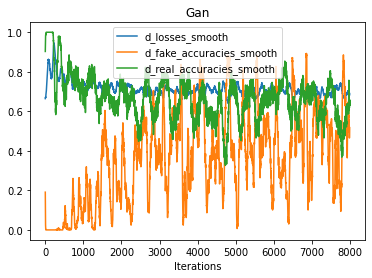

In [314]:
from typing import List

def plot_metric_general(graphs: List[np.ndarray], labels: List[str]) -> None:
    import matplotlib.pyplot as plt
    iterations = range(1, graphs[0].shape[0] + 1)
    plt.xlabel("Iterations")
    plt.title('Gan')
    for i in range(len(labels)):
        plt.plot(iterations, graphs[i])
    plt.legend(labels)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
  
d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth = moving_average(d_losses.reshape((iterations)), 9), moving_average(d_fake_accuracies.reshape((iterations)), 9), moving_average(d_real_accuracies.reshape((iterations)), 9)

plot_metric_general([d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth], ['d_losses_smooth', 'd_fake_accuracies_smooth', 'd_real_accuracies_smooth'])

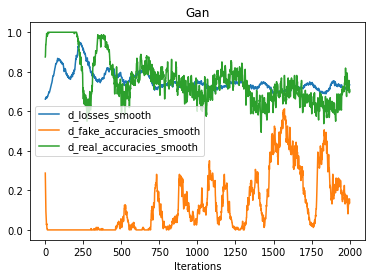

In [315]:
d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth = moving_average(d_losses.reshape((iterations)), 5), moving_average(d_fake_accuracies.reshape((iterations)), 5), moving_average(d_real_accuracies.reshape((iterations)), 5)
plot_metric_general([d_losses_smooth[:2000], d_fake_accuracies_smooth[:2000], d_real_accuracies_smooth[:2000]], ['d_losses_smooth', 'd_fake_accuracies_smooth', 'd_real_accuracies_smooth'])
# we can see aroud 800 iteration d_fake_accuracies=d_real_accuracies=0.5 and after that they wobbles one against the other

In [316]:
# import matplotlib.pyplot as plt
# def show_plot(arr):
#   x = range(arr.shape[0])
#   plt.plot(x, arr)

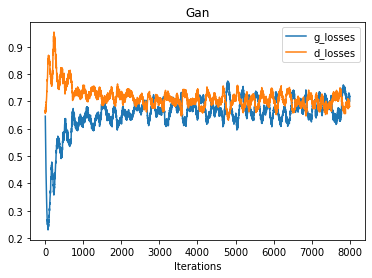

In [317]:
g_losses_smooth, d_losses_smooth = moving_average(g_losses.reshape((iterations)), 3), moving_average(d_losses.reshape((iterations)), 3)
# graph describing the loss of the generator and the discriminator
# models go “back and forth” with their losses, there was no a consistent leader
plot_metric_general([g_losses_smooth, d_losses_smooth], ['g_losses', 'd_losses'])

In [318]:
X_train = df_credit.values
y_real = np.ones((X_train.shape[0], 1))

# evaluation experiment on diabetes
print ('real evaluation experiment on all data set')
_, acc_real = gan.discriminator.evaluate(X_train, y_real, verbose=1)
y_fake = np.zeros((100, 1))
noise = np.random.normal(0, 1, (100, gan.latent_dim))
x_fake =gan.generator.predict(noise)
print ('fake evaluation experiment on 100 samples')
_, acc_facke = gan.discriminator.evaluate(x_fake, y_fake, verbose=1)

real evaluation experiment on all data set
32/32 [==============================] - 0s 2ms/step - loss: 0.6635 - accuracy: 0.6440
fake evaluation experiment on 100 samples
4/4 [==============================] - 0s 3ms/step - loss: 0.6888 - accuracy: 0.5000


# Evaluate goodness of generated samples 
how to Use basic measures (e.g., Euclidean distance, basic visualization) determine whether the samples that fooled the detector are indeed similar to some of the original data

1- we can calculate the Gausian distribution of each column and check how close it is to real sample distribution

In [319]:
gan.generator.save('generator_model_5000.h5')

In [320]:
# we can check for models checkpoints produced good generative samples
loaded_generator = tf.keras.models.load_model('generator_model_5000.h5')
noise = np.random.normal(0, 1, (100, gan.latent_dim))
x_fake = loaded_generator.predict(noise)
# print('x_fake \n', x_fake)
print ('fake loaded_generator evaluation experiment on 100 samples')
_, acc_facke = gan.discriminator.evaluate(x_fake, y_fake, verbose=1)


fake loaded_generator evaluation experiment on 100 samples
4/4 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4600
